In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import Optimizer, Adam
from torch.types import Number
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [89]:
from typing import cast, Any, overload, Generic
from typing_extensions import TypeVar
from matplotlib.figure import Figure
from matplotlib.axes import Axes

T_co = TypeVar("T_co", covariant=True, default=Tensor)

In [90]:
from tqdm.notebook import tqdm

In [91]:
project_name = "project-plant-identification"

In [141]:
from modules.dataset import (
    DATASET_BASEDIR,
    DATASET_DIR,
    DATASET_AUGMENTED_DIR,
    DATASET_ORIG_DIR,
    UNIQUE_PLANTS,
)
from modules.dataset import TRANSFORM
from modules.dataset import inv_norm


os.listdir(DATASET_BASEDIR)

['Flavia', 'New Plant-Dataset', 'Random']

In [93]:
os.listdir(DATASET_DIR)

['augmented',
 'augmented_features.csv',
 'original',
 'processed_features.csv',
 'valid']

In [94]:
_classes = os.listdir(DATASET_AUGMENTED_DIR)
_classes

['Arjun Leaf',
 'Curry Leaf',
 'Marsh Pennywort Leaf',
 'Mint Leaf',
 'Neem Leaf',
 'Rubble Leaf',
 'Z',
 'ZZ']

In [95]:
from statistics import mean


AVERAGE_NUMBER_OF_IMAGES = mean(
    len(os.listdir(DATASET_AUGMENTED_DIR / i))
    for i in os.listdir(DATASET_AUGMENTED_DIR)
)
AVERAGE_NUMBER_OF_IMAGES

1610

In [96]:
print("Number of Classes: ", len(UNIQUE_PLANTS))
print("Classes: ", UNIQUE_PLANTS)

Number of Classes:  8
Classes:  ['Arjun Leaf', 'Curry Leaf', 'Marsh Pennywort Leaf', 'Mint Leaf', 'Neem Leaf', 'Rubble Leaf', 'Z', 'ZZ']


In [97]:
dataset = ImageFolder(str(DATASET_AUGMENTED_DIR), transform=TRANSFORM)
orig_ds = ImageFolder(str(DATASET_ORIG_DIR), transform=TRANSFORM)

In [98]:
print("Number of training images: ", len(dataset))
print("Number of original images: ", len(orig_ds))

Number of training images:  12880
Number of original images:  1380


In [99]:
num_classes = dataset.classes
print("Number of classes: ", len(num_classes))
print(*num_classes, sep="\n")

Number of classes:  8
Arjun Leaf
Curry Leaf
Marsh Pennywort Leaf
Mint Leaf
Neem Leaf
Rubble Leaf
Z
ZZ


In [100]:
print(*orig_ds.classes, sep="\n")

Arjun Leaf
Curry Leaf
Marsh Pennywort Leaf
Mint Leaf
Neem Leaf
Rubble Leaf


Image shape: torch.Size([3, 256, 256])
Image Label:  0
Image Label:  Arjun Leaf


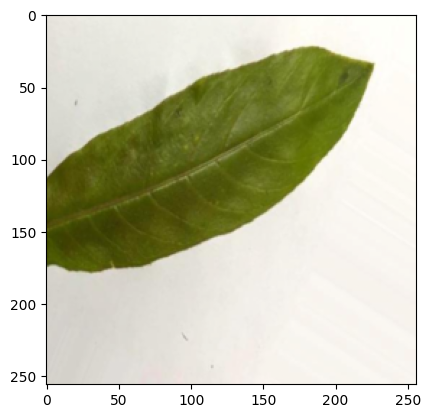

In [101]:
image, label = dataset[0]
print("Image shape:", image.shape)
print("Image Label: ", label)
print("Image Label: ", num_classes[label])
plt.imshow(inv_norm(image).permute(1, 2, 0))

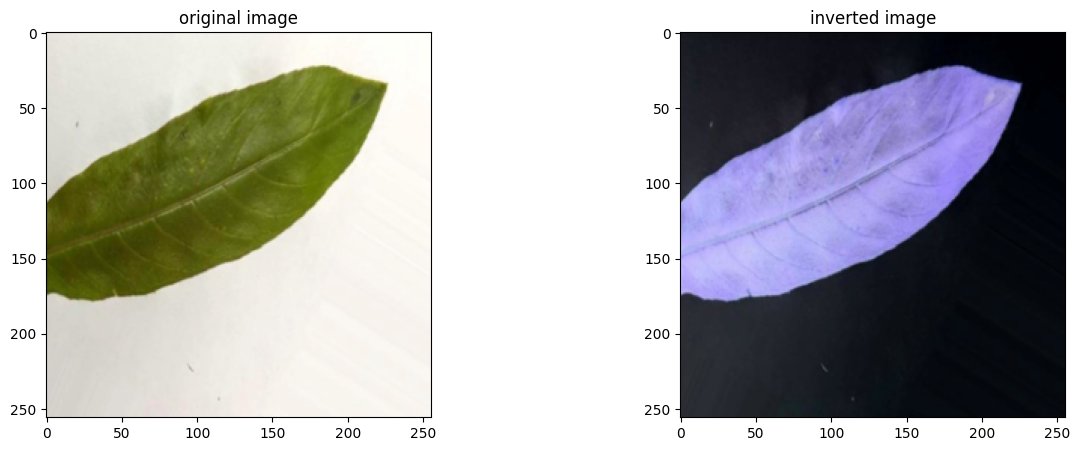

In [102]:
fig, (ax1, ax2) = cast(
    tuple[Figure, tuple[Axes, Axes]], plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
)
unnormalized_image = inv_norm(image)
ax1.imshow(unnormalized_image.permute(1, 2, 0))
ax1.set_title("original image")
ax2.imshow(1 - unnormalized_image.permute(1, 2, 0))
ax2.set_title("inverted image")
plt.show()

In [103]:
random_seed = 42
torch.manual_seed(random_seed)  # type: ignore

In [104]:
dataset_length = len(dataset)
validation_split = 0.3
val_size = int(dataset_length * validation_split)
train_size = dataset_length - val_size


dataset_length, train_size, val_size, dataset_length == train_size + val_size

(12880, 9016, 3864, True)

In [105]:
TRAIN_DATASET, TEST_DATASET = random_split(dataset, (train_size, val_size))

In [106]:
batch_size = 64

TRAIN_LOADER = DataLoader(
    TRAIN_DATASET, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)
TEST_LOADER = DataLoader(
    TEST_DATASET, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)
ORIG_LOADER = DataLoader(
    orig_ds, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)

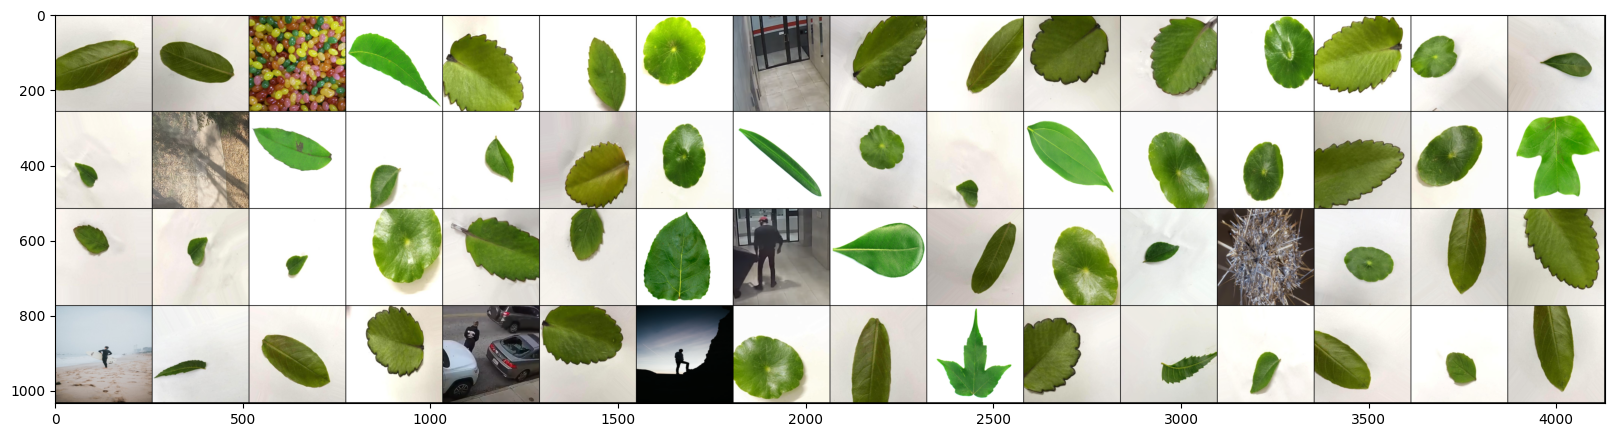

In [107]:
for images, labels in TRAIN_LOADER:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.imshow(make_grid(inv_norm(images.cpu()), nrow=16).permute(1, 2, 0))
    break

In [108]:
def accuracy(outputs: Tensor, labels: Tensor):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [109]:
class ImageClassificationBase(nn.Module):
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)  # type: ignore

    def training_step(self, batch: Tensor | list[Tensor]):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch: Tensor | list[Tensor]):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss, "val_acc": acc}

    def validation_epoch_end(self, outputs: list[dict[str, Tensor]]):
        batch_loss = [out["val_loss"] for out in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [out["val_acc"] for out in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch: int, result: dict[str, Number]):
        print(
            "Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["train_loss"], result["val_loss"], result["val_acc"]
            )
        )

In [110]:
class Herbal_Identification_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 64*64*64
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 128*32*32
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 256*16*16
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 512*8*8
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 1024*4*4
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 38),
        )

    def forward(self, xb: Tensor) -> Tensor:
        out = self.network(xb)
        return out

In [111]:
class Herbal_Identification_Model1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.vgg16(pretrained=True)
        num_ftrs = self.network.classifier[-1].in_features
        self.network.classifier[-1] = nn.Linear(num_ftrs, 38)

    def forward(self, xb: Tensor) -> Tensor:
        out = self.network(xb)
        return out

In [112]:
class Herbal_Identification_Model2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 38)

    def forward(self, xb: Tensor) -> Tensor:
        out = self.network(xb)
        return out

In [113]:
from modules.device import DEVICE, to_device
from modules.device import DeviceDataLoader


DEVICE

device(type='cuda')

In [116]:
TRAIN_LOADER = DeviceDataLoader(TRAIN_LOADER, DEVICE)
TEST_LOADER = DeviceDataLoader(TEST_LOADER, DEVICE)
ORIG_LOADER = DeviceDataLoader(ORIG_LOADER, DEVICE)

In [117]:
model = to_device(Herbal_Identification_Model2(), DEVICE)

In [118]:
model

Herbal_Identification_Model2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [119]:
@torch.no_grad()  # type: ignore
def evaluate(model: ImageClassificationBase, val_loader: DeviceDataLoader[Any]):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [120]:
def fit(
    epochs: int,
    model: ImageClassificationBase,
    train_loader: DeviceDataLoader[Any],
    val_loader: DeviceDataLoader[Any],
    optimizer: Optimizer,
):
    history: list[dict[str, Number]] = []
    for epoch in range(epochs):
        model.train()
        train_losses: list[Tensor] = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()  # type: ignore
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [121]:
history = fit(25, model, TRAIN_LOADER, TEST_LOADER, Adam(model.parameters(), 0.001))

  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1155, val_loss: 0.7760, val_acc: 0.8694


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0391, val_loss: 0.0280, val_acc: 0.9933


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0190, val_loss: 0.0030, val_acc: 0.9992


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0027, val_loss: 0.0028, val_acc: 0.9995


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0060, val_loss: 0.0056, val_acc: 0.9990


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0584, val_loss: 0.1035, val_acc: 0.9670


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0191, val_loss: 0.0322, val_acc: 0.9946


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0176, val_loss: 0.1616, val_acc: 0.9664


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0213, val_loss: 0.0113, val_acc: 0.9967


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0107, val_loss: 0.1975, val_acc: 0.9476


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0123, val_loss: 0.0046, val_acc: 0.9987


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.0024, val_loss: 0.0176, val_acc: 0.9954


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0131, val_loss: 0.0119, val_acc: 0.9959


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0117, val_loss: 0.0061, val_acc: 0.9982


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0069, val_loss: 0.0172, val_acc: 0.9951


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.0291, val_loss: 0.0042, val_acc: 0.9992


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.0060, val_loss: 0.0332, val_acc: 0.9893


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.0422, val_loss: 0.0108, val_acc: 0.9959


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.0113, val_loss: 0.0050, val_acc: 0.9977


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.0018, val_loss: 0.0031, val_acc: 0.9990


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.0017, val_loss: 0.0049, val_acc: 0.9987


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.0066, val_loss: 0.0042, val_acc: 0.9990


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.0144, val_loss: 0.0376, val_acc: 0.9868


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.0124, val_loss: 0.0126, val_acc: 0.9959


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0068, val_loss: 0.0033, val_acc: 0.9990


In [122]:
# evaluate(model, TEST_LOADER)

In [123]:
# history = fit(5, model, TRAIN_LOADER, TEST_LOADER, Adam(model.parameters(), 0.001))

In [124]:
def plot_losses(history: list[dict[str, Number]]):
    train_losses = [x["train_loss"] for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")

In [125]:
def plot_accuracies(history: list[dict[str, Number]]):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")

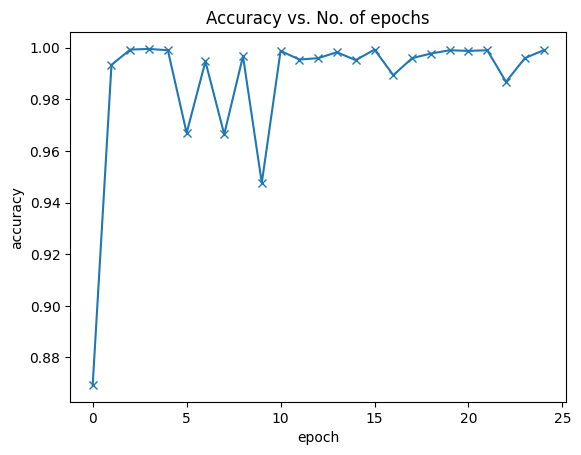

In [126]:
plot_accuracies(history)

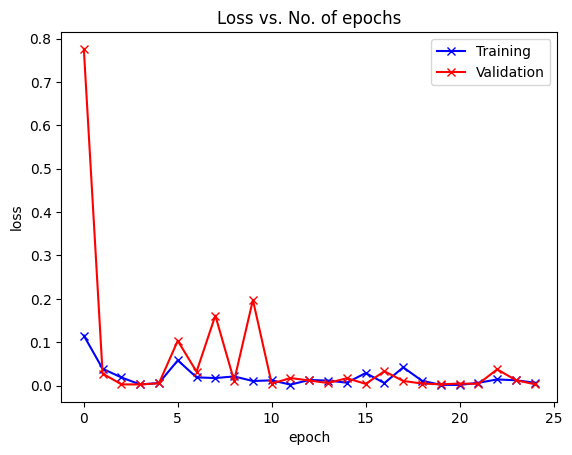

In [127]:
plot_losses(history)

In [128]:
evaluate(model, TEST_LOADER)

{'val_loss': 0.003336370224133134, 'val_acc': 0.998975396156311}

In [129]:
x = evaluate(model, ORIG_LOADER)
x

{'val_loss': 0.0003959198947995901, 'val_acc': 1.0}

In [130]:
def predict_image(img: Tensor, model: ImageClassificationBase):
    xb = to_device(img.unsqueeze(0), DEVICE)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    i = cast(int, preds[0].item())
    print(i, type(i))
    return dataset.classes[i]

0 <class 'int'>
Label: Arjun Leaf , Predicted: Arjun Leaf


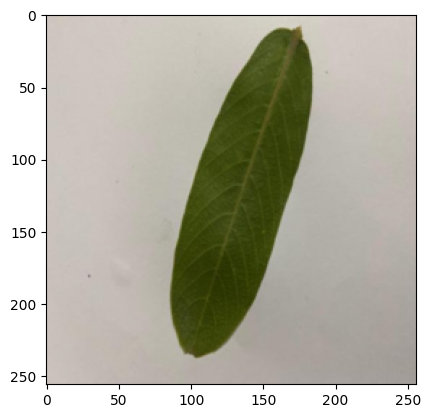

In [131]:
img, label = orig_ds[25]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

4 <class 'int'>
Label: Neem Leaf , Predicted: Neem Leaf


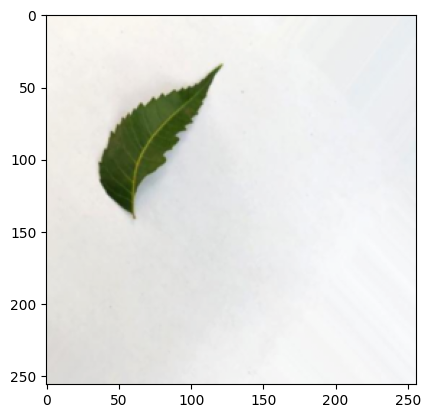

In [132]:
img, label = TRAIN_DATASET[25]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

4 <class 'int'>
Label: Neem Leaf , Predicted: Neem Leaf


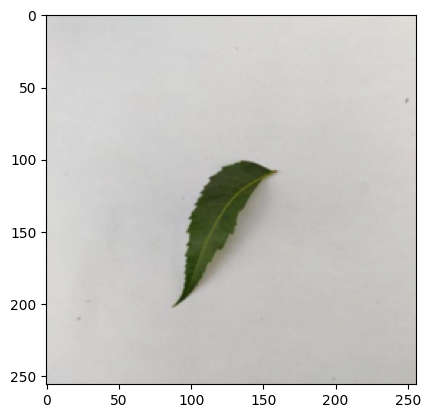

In [133]:
img, label = orig_ds[978]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

1 <class 'int'>
Label: Curry Leaf , Predicted: Curry Leaf


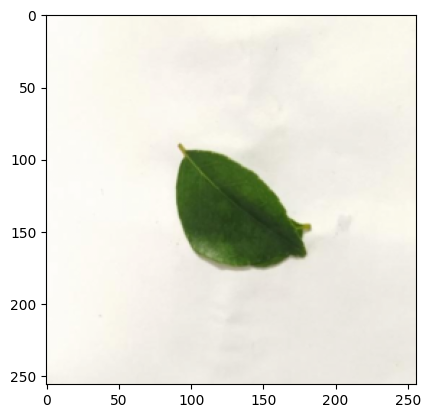

In [134]:
img, label = orig_ds[258]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

In [135]:
print(len(orig_ds))

1380


In [136]:
for i in range(len(orig_ds)):
    path, target = orig_ds.samples[i]
    print("Sample {}: Path: {}, Target: {}".format(i, path, target))

Sample 0: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (1).JPG, Target: 0
Sample 1: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (10).JPG, Target: 0
Sample 2: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (100).JPG, Target: 0
Sample 3: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (101).JPG, Target: 0
Sample 4: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (102).JPG, Target: 0
Sample 5: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (103).JPG,

In [137]:
torch.save(model.state_dict(), "../models/herbal-identification-new-resnet34.pth")

In [138]:
x = [x]

# Check the content and structure of x
print(x)

# Verify the data type of x[0]
print(type(x[0]))

# Assuming x[0] is a dictionary, access the keys 'val_acc' and 'val_loss'
if isinstance(x[0], dict):
    test_acc = x[0].get("val_acc")
    test_loss = x[0].get("val_loss")
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
else:
    print("x[0] is not a dictionary as expected.")

[{'val_loss': 0.0003959198947995901, 'val_acc': 1.0}]
<class 'dict'>
Test Accuracy: 1.0
Test Loss: 0.0003959198947995901


In [139]:
if isinstance(x[0], dict):
    test_acc = x[0].get("val_acc")
    test_loss = x[0].get("val_loss")
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
elif isinstance(x[0], str):
    print("Evaluation result is a string:", x[0])
    # Handle the string result accordingly
else:
    print("Unexpected type for x[0]:", type(x[0]))

Test Accuracy: 1.0
Test Loss: 0.0003959198947995901
